## 2. Kreuzvalidierung und Modellselektion

Bei der Methode der Kreuzvalidierung wird der zufällige Split in Trainings- und Testdatensatz aus Aufgabe 1 mehrere Male wiederholt und der Durchschnitt über mehrere Splits berechnet, um eine genauere Schätzung der wirklichen Treffergenauigkeit zu erhalten. *Scikit Learn* stellt dafür bereits eine vordefinierte Methode zur Verfügung: `sklearn.model_selection`. Die Methode verwendet die Iteratorsyntax von Python, Beispiele zur Verwendung finden Sie in der Dokumentation dieser Methode. `ShuffleSplit()` erzeugt einen Satz von permutierten Indizes von Trainings- und Testdaten.

Aufgaben:

a) Erzeugen Sie zunächst 3 Sätze und trainieren Sie für jeden Satz eine SVM mit $\gamma = 0.001$ und $C = 1$ und geben Sie jeweils die Treffergenauigkeit für Trainings- und Testdatensatz aus. Die Ergebnisse sollten ähnlich wie in Aufgabe 1b aussehen.

In [64]:
### 3.2 a)
from sklearn import datasets

# Get the data
digits = datasets.load_digits()

In [65]:
from sklearn import model_selection, svm

for i in range(3):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(digits.data, digits.target, test_size=0.25)
    clf = svm.SVC(C=100.0, gamma=0.001, kernel="rbf")
    clf.fit(train_data, train_label)
        
    print(f"""
    Model {i}:
    Score on Train:\t{round(clf.score(train_data, train_label), 3)}
    Score on Test:\t{round(clf.score(test_data, test_label), 3)}
    """)


    Model 0:
    Score on Train:	1.0
    Score on Test:	0.993
    

    Model 1:
    Score on Train:	1.0
    Score on Test:	0.989
    

    Model 2:
    Score on Train:	1.0
    Score on Test:	0.989
    


b) Statt wie in 2a von Hand vorzugehen gibt es in *Scikit Learn* die bereits vordefinierte Methode `sklearn.model_selection.cross_val_score()`. Wiederholen Sie Ihr Experiment aus Aufgabe 2a mit 10 Zufallssplits und geben Sie jeweils die Treffergenauigkeit auf dem Testdatensatz aus. Berechnen Sie die mittlere Treffergenauigkeit (die **Kreuzvalidierungsgenauigkeit**) und die Standardabweichung des Mittelwerts.

In [66]:
### 3.2 b)
train_data, test_data, train_label, test_label = model_selection.train_test_split(digits.data, digits.target, test_size=0.25)

clf = svm.SVC(C=100.0, gamma=0.001, kernel="rbf")
scores = model_selection.cross_val_score(estimator=clf,
                                         X=test_data,
                                         y=test_label,
                                         cv=10)

print(f"""
Cross Validation Scores:
Kreuzvalidierungsgenauigkeit:\t{round(scores.mean(), 3)}
Standardabweichung:\t\t\t\t{round(scores.std(), 3)}
""")


Cross Validation Scores:
Kreuzvalidierungsgenauigkeit:	0.971
Standardabweichung:				0.024


c) Mithilfe der Kreuzvalidierungsgenauigkeit können die optimalen $\gamma$- und $C$-Parameter der SVM automatisch gefunden werden. Dieser Vorgang heißt Modellselektion. Man führt zu diesem Zweck eine Gittersuche durch: zunächst wird ein Satz von Werten für $\gamma$ und $C$ festgelegt. Für alle Wertepaare wird die Kreuzvalidierungsgenauigkeit bestimmt und dann
die Parameter gewählt, die die höchste Treffergenauigkeit erzielen. Finden Sie auf diese Weise für $C = 10$ den besten Gammawert aus einem Satz von 10 logarithmisch skalierten Gammawerten, erzeugt mit

In [67]:
### 3.2 c)
import numpy as np
gammas = np.logspace(-7, -1, 10)
gammas

array([1.00000000e-07, 4.64158883e-07, 2.15443469e-06, 1.00000000e-05,
       4.64158883e-05, 2.15443469e-04, 1.00000000e-03, 4.64158883e-03,
       2.15443469e-02, 1.00000000e-01])

Verwenden Sie dazu eine Trainings- und Testdatensatzgröße von 500 und 5 Splits (s. Dokumentation von `ShuffleSplit`) und speichern Sie die Treffergenauigkeit auf dem Trainings- und Testdatensatz für jeden Gammawert und Split. Plotten Sie die Treffergenauigkeitskurve für jeden Split mit dem Gammawert als Abszisse in einem gemeinsamen Diagramm, jeweils für die Trainings- und die Testdaten. Diese Kurven werden **Validierungskurven** genannt
(s.u.). Für welche Gammawerte erhalten Sie Underfitting, für welche Overfitting? Wo liegt der optimale Gammawert?

<img src="validierungskurve.png" alt="drawing" width="500"/>

In [68]:
results_train = []
results_test = []

rs = model_selection.ShuffleSplit(n_splits=5, train_size=500, test_size=500, random_state=0)
for i, (train_index, test_index) in enumerate(rs.split(digits.data)):
    print(f"Fold {i}...")
    
    train_data = digits.data[train_index]
    train_label = digits.target[train_index]
    test_data = digits.data[test_index]
    test_label = digits.target[test_index]
    
    scores_train = []
    scores_test = []
    
    for g in gammas:
        clf = svm.SVC(C=10.0, gamma=g, kernel="rbf")
        clf.fit(train_data, train_label)
        
        scores_train.append(clf.score(train_data, train_label))
        scores_test.append(clf.score(test_data, test_label))
    
    results_train.append(scores_train)
    results_test.append(scores_test)

Fold 0...
Fold 1...
Fold 2...
Fold 3...
Fold 4...


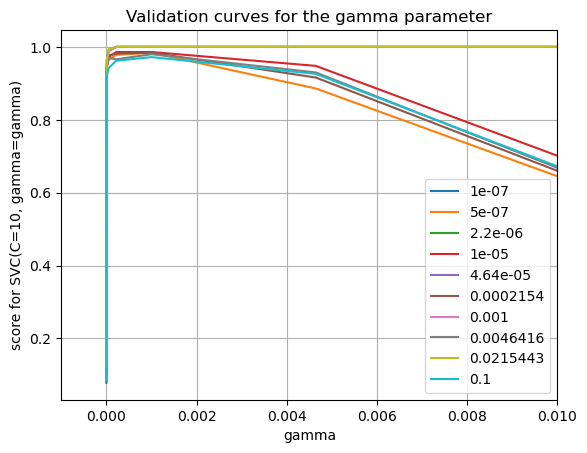

In [69]:
from matplotlib import pyplot as plt

# Plot the results for train and test
for _, (scores_tr, scores_te) in enumerate(zip(results_train, results_test)):
    plt.plot(gammas, scores_tr)
    plt.plot(gammas, scores_te)
plt.xlim(-0.001, 1e-2)
plt.legend(np.around(gammas, 7))
plt.title("Validation curves for the gamma parameter")
plt.xlabel("gamma")
plt.ylabel("score for SVC(C=10, gamma=gamma)")
plt.grid(True)
plt.show()

d) Die Gittersuche lässt sich ebenfalls automatisieren mit `sklearn.model_selection. GridSearchCV()`. Wir erzeugen dazu ein Gitter aus Wertepaaren für $\gamma$ und $C$ mit dem Dictionary

In [70]:
svc_params = {
    'C': np.logspace(-1, 2, 4),
    'gamma': np.logspace(-4, 0, 5), 
}

Dieses Gitter kann direkt an `GridSearchCV()` als Argument `param_grid` übergeben werden. Da diese Prozedur sehr zeitaufwendig ist, verkleinern wie den Datensatz auf die ersten 500 Beispiele. Führen Sie für diesen verkleinerten Datensatz eine Gittersuche mithilfe von `GridSearchCV()` und jeweils 3 Splits (Parameter `cv`) durch. Den besten Parametersatz erhalten Sie mit `GridSearchCV().best_params_`, die höchste Treffergenauigkeit mit `GridSearchCV().best_score_`. Ausführliche Informationen zu jedem Parameterwertepaar stehen in dem Dictionary `GridSearchCV().cv_results_`. Nach der Gittersuche führt `GridSearchCV()` noch ein Training auf dem gesamten Datensatz mit den besten Parametern durch, so dass die resultierende Maschine sofort eingesetzt werden kann. Testen Sie diese Maschine auf den übriggebliebenen Daten.

In [71]:
svc = svm.SVC(kernel="rbf")
clf = model_selection.GridSearchCV(estimator=svc, param_grid=svc_params, cv=3)
clf.fit(digits.data[:500], digits.target[:500])

print(f"""
Best Params:\t{clf.best_params_}
Best Score:\t\t{clf.best_score_}
Score on Test data:\t{clf.score(digits.data[500:], digits.target[500:])}
""")


Best Params:	{'C': 100.0, 'gamma': 0.0001}
Best Score:		0.9219031815886299
Score on Test data:	0.9414032382420972


In [72]:
print("Detailed results:")
print(clf.cv_results_)

Detailed results:
{'mean_fit_time': array([0.02603793, 0.01562444, 0.04166993, 0.02603642, 0.03402535,
       0.01042056, 0.01562413, 0.02604135, 0.02604183, 0.03125366,
       0.01561968, 0.01562349, 0.01563875, 0.03123879, 0.03126184,
       0.00579675, 0.01356339, 0.0163397 , 0.01563803, 0.02086242]), 'std_fit_time': array([7.36946083e-03, 2.17064226e-06, 3.68304023e-02, 7.36198808e-03,
       9.56259000e-03, 7.36845011e-03, 1.75561285e-06, 7.36615416e-03,
       7.36580803e-03, 1.27569826e-02, 6.71627954e-06, 3.32206060e-05,
       1.70879585e-05, 1.17576866e-05, 2.87617099e-05, 8.19784301e-03,
       1.52262654e-03, 9.84274566e-04, 1.81994584e-05, 7.35153461e-03]), 'mean_score_time': array([0.01567419, 0.00521104, 0.01562206, 0.01563152, 0.02083635,
       0.01279147, 0.0104173 , 0.01041691, 0.01041675, 0.01562556,
       0.        , 0.00520809, 0.01041555, 0.        , 0.01042175,
       0.01340111, 0.00233332, 0.01198196, 0.01041754, 0.0155956 ]), 'std_score_time': array([7.07559